# Mixed-Integer Linear Programming

Importing gurobi MIP solver and other required libraries

In [45]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import os
import csv

from utils.utils import load_data, plot_device, plot_device_rotation, write_sol, write_stat_line, plot_bar_graph

## Models
### No rotation

In [2]:
def bounds(w, n, widths, heights, verbose=0):
    # Create a new model
    m = gp.Model('standard')

    # Calculatin bounds
    chip_height_lb = min(heights)
    height_lb = (np.array(widths)@np.array(heights)) / w
    height_ub = sum(heights)
    x_ub = w - min(widths)
    y_ub = height_ub - min(heights)

    # Create variables
    coordinates_x = [m.addVar(vtype='I', name=f'x_{i}', ub=x_ub) for i in range(n)]
    coordinates_y = [m.addVar(vtype='I', name=f'y_{i}', ub=y_ub) for i in range(n)]
    chip_heights = [m.addVar(vtype='I', name=f'max_y_{i}', lb=chip_height_lb, ub=height_ub) for i in range(n)]
    max_height = m.addVar(vtype='I', name='max_height', lb=height_lb, ub=height_ub)

    # Add constraints
    # Maximum heights
    m.addConstrs((chip_heights[i] == coordinates_y[i] + heights[i] for i in range(n)))
    # Maximum height
    m.addConstr(max_height == gp.max_(chip_heights))

    # Total width constraint
    for i in range(n):
        m.addConstr(coordinates_x[i] + widths[i] <= w)

    # No overlap constraints
    for i in range(n):
        for j in range(i + 1, n):
            j_is_left = m.addVar(vtype='B', name=f'j_is_left_{i}_{j}')
            m.addGenConstrIndicator(j_is_left, True, coordinates_x[i] >= coordinates_x[j] + widths[j])

            j_is_right = m.addVar(vtype='B', name=f'j_is_right_{i}_{j}')
            m.addGenConstrIndicator(j_is_right, True, coordinates_x[i] + widths[i] <= coordinates_x[j])

            j_is_down = m.addVar(vtype='B', name=f'j_is_down_{i}_{j}')
            m.addGenConstrIndicator(j_is_down, True, coordinates_y[i] >= coordinates_y[j] + heights[j])

            j_is_up = m.addVar(vtype='B', name=f'j_is_up_{i}_{j}')
            m.addGenConstrIndicator(j_is_up, True, coordinates_y[i] + heights[i] <= coordinates_y[j])

            m.addConstr(j_is_left + j_is_right + j_is_down + j_is_up >= 1)

    # Set objective function
    m.setObjective(max_height, gp.GRB.MINIMIZE)

    # Solve it!
    m.Params.output_flag = verbose
    m.Params.time_limit = 300.0

    return m, coordinates_x, coordinates_y, max_height, height_lb


In [3]:
def strong_bounds(w, n, widths, heights, verbose=0):
    # Create a new model
    m = gp.Model('strong_bounds')

    # Calculating bounds
    height_lb = (np.array(widths)@np.array(heights)) / w
    height_ub = sum(heights)

    # Create variables
    coordinates_x = [m.addVar(vtype='I', name=f'x_{i}', ub=w - widths[i]) for i in range(n)]
    coordinates_y = [m.addVar(vtype='I', name=f'y_{i}', ub=height_ub - heights[i]) for i in range(n)]
    chip_heights = [m.addVar(vtype='I', name=f'max_y_{i}', lb=heights[i], ub=height_ub) for i in range(n)]
    max_height = m.addVar(vtype='I', name='max_height', lb=height_lb, ub=height_ub)

    # Add constraints
    # Maximum heights
    m.addConstrs((chip_heights[i] == coordinates_y[i] + heights[i] for i in range(n)))
    # Maximum height
    m.addConstr(max_height == gp.max_(chip_heights))

    # No overlap constraints
    for i in range(n):
        for j in range(i + 1, n):
            j_is_left = m.addVar(vtype='B', name=f'j_is_left_{i}_{j}')
            m.addGenConstrIndicator(j_is_left, True, coordinates_x[i] >= coordinates_x[j] + widths[j])

            j_is_right = m.addVar(vtype='B', name=f'j_is_right_{i}_{j}')
            m.addGenConstrIndicator(j_is_right, True, coordinates_x[i] + widths[i] <= coordinates_x[j])

            j_is_down = m.addVar(vtype='B', name=f'j_is_down_{i}_{j}')
            m.addGenConstrIndicator(j_is_down, True, coordinates_y[i] >= coordinates_y[j] + heights[j])

            j_is_up = m.addVar(vtype='B', name=f'j_is_up_{i}_{j}')
            m.addGenConstrIndicator(j_is_up, True, coordinates_y[i] + heights[i] <= coordinates_y[j])

            m.addConstr(j_is_left + j_is_right + j_is_down + j_is_up >= 1)

    # Set objective function
    m.setObjective(max_height, gp.GRB.MINIMIZE)

    # Solve it!
    m.Params.output_flag = verbose
    m.Params.time_limit = 300.0
    
    return m, coordinates_x, coordinates_y, max_height, height_lb

### Rotation

In [29]:
def standard_rotation(w, n, widths, heights, verbose=0):
    # Create a new model
    m = gp.Model('standard_rotation')

    heights_and_widths = np.concatenate((np.array(widths), np.array(heights)))
    min_value = heights_and_widths.min()
    rotated_widths = heights
    rotated_heights = widths
    
    # Calculatin bounds
    chip_height_lb = min_value
    height_lb = (np.array(widths)@np.array(heights)) / w
    height_ub = sum(heights)
    x_ub = w - min_value
    y_ub = height_ub - min_value

    # Create variables
    coordinates_x = [m.addVar(vtype='I', name=f'x_{i}', ub=x_ub) for i in range(n)]
    coordinates_y = [m.addVar(vtype='I', name=f'y_{i}', ub=y_ub) for i in range(n)]
    chip_heights = [m.addVar(vtype='I', name=f'max_y_{i}', lb=chip_height_lb, ub=height_ub) for i in range(n)]
    max_height = m.addVar(vtype='I', name='max_height', lb=height_lb, ub=height_ub)
    rotated = [m.addVar(vtype='B', name=f'{i}_rotated') for i in range(n)]

    # Add constraints
    # Maximum heights
    m.addConstrs((chip_heights[i] == coordinates_y[i] + heights[i]*(1 - rotated[i]) + rotated_heights[i]*rotated[i] for i in range(n)))
    # Maximum height
    m.addConstr(max_height == gp.max_(chip_heights))

    # Total width constraint
    for i in range(n):
        m.addConstr(coordinates_x[i] + widths[i]*(1 - rotated[i]) + rotated_widths[i]*rotated[i] <= w)

    # No overlap constraints
    for i in range(n):
        for j in range(i + 1, n):
            j_is_left = m.addVar(vtype='B', name=f'j_is_left_{i}_{j}')
            m.addGenConstrIndicator(j_is_left, True, coordinates_x[i] >= coordinates_x[j] + widths[j]*(1 - rotated[j]) + rotated_widths[j]*rotated[j])

            j_is_right = m.addVar(vtype='B', name=f'j_is_right_{i}_{j}')
            m.addGenConstrIndicator(j_is_right, True, coordinates_x[i] + widths[i]*(1 - rotated[i]) + rotated_widths[i]*rotated[i] <= coordinates_x[j])

            j_is_down = m.addVar(vtype='B', name=f'j_is_down_{i}_{j}')
            m.addGenConstrIndicator(j_is_down, True, coordinates_y[i] >= coordinates_y[j] + heights[j]*(1 - rotated[j]) + rotated_heights[j]*rotated[j])

            j_is_up = m.addVar(vtype='B', name=f'j_is_up_{i}_{j}')
            m.addGenConstrIndicator(j_is_up, True, coordinates_y[i] + heights[i]*(1 - rotated[i]) + rotated_heights[i]*rotated[i] <= coordinates_y[j])

            m.addConstr(j_is_left + j_is_right + j_is_down + j_is_up >= 1)

    # Set objective function
    m.setObjective(max_height, gp.GRB.MINIMIZE)

    # Solve it!
    m.Params.output_flag = verbose
    m.Params.time_limit = 300.0
    
    return m, coordinates_x, coordinates_y, max_height, height_lb

## Tuning

In [5]:
# Tuning was done with instance 17 in 300 seconds
def tune(model, time_limit=300.0):
    model.Params.tune_time_limit = time_limit
    model.tune()
    
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write('tune'+str(i)+'.prm')

## Execution
#### Models dictionary

In [30]:
models = {
    "standard": bounds,
    "strong_bounds": strong_bounds,
    "tuned_standard": bounds,
    "tuned_strong_bounds": strong_bounds,
    'standard_rotation': standard_rotation,
    "test": bounds
}

#### Execution function

In [43]:
def execute(instance, exec_name, tuned_parameters_path=None, rotated=False, save_sol=True, display_image=True, save_image=True, save_stats=True, verbose=0):
    path = os.path.abspath('')

    w, n, widths, heights = load_data(instance)
    
    model, coordinates_x, coordinates_y, max_height, height_lb = models[exec_name](w, n, widths, heights, verbose=verbose)
    
    if tuned_parameters_path is not None:
        model.read(tuned_parameters_path)
    
    model.optimize()
    
    runtime, c_x, c_y, h = model.getAttr('runtime'), [v.X for v in coordinates_x], [v.X for v in coordinates_y], max_height.X

    if rotated:
        rotated = [bool(model.getVarByName(f'{i}_rotated').X) for i in range(n)]
        if display_image:
            plot_device_rotation(c_x, c_y, widths, heights, w, h, rotated)
        if save_image:
            plot_device_rotation(c_x, c_y, widths, heights, w, h, rotated, path + f'/img/{exec_name}/{instance}.png')
    else:
        if display_image:
            plot_device(c_x, c_y, widths, heights, w, h)
        if save_image:
            plot_device(c_x, c_y, widths, heights, w, h, path + f'/img/{exec_name}/{instance}.png')

            
    if save_sol:
        write_sol(path + f'/out/{exec_name}/{instance}.txt', w, h, n, widths, heights, c_x, c_y)

    
    if save_stats:
        write_stat_line(os.path.abspath('') + f'/stats/{exec_name}.csv', i, h, height_lb, runtime)


    return runtime, h, height_lb


In [ ]:
exec_name = 'tuned_standard'
for i in range(1, 2):
    runtime, h, h_lb = execute(i, exec_name, tuned_parameters_path='tune0.prm', display_image=False)
    print(f'Executed instance {i} in {runtime} seconds.\nHeight found is {h} and the lower bound was {h_lb}.\n')


C:\Users\giach\OneDrive\Documenti\Uni\Magistrale\Primo Anno\Combinatorial Decision Making and Optimization\Combinatorial_Project\utils\..\instances\ins-26.txt
Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-29


C:\Users\giach\OneDrive\Documenti\Uni\Magistrale\Primo Anno\Combinatorial Decision Making and Optimization\Combinatorial_Project\utils\..\instances\ins-18.txt


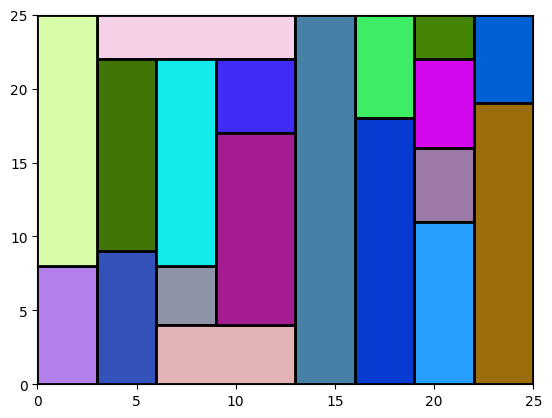

Execution time: 258.92848205566406
Height of the silicon plate: 25.0


In [49]:
%matplotlib inline
exec_name= 'standard_rotation'
i = 18
r, h, h_lib = execute(i, exec_name, rotated=True, save_sol=False, save_image=False, save_stats=False)
print(f'Execution time: {r}\nHeight of the silicon plate: {h}')

### Results

<IPython.core.display.Javascript object>


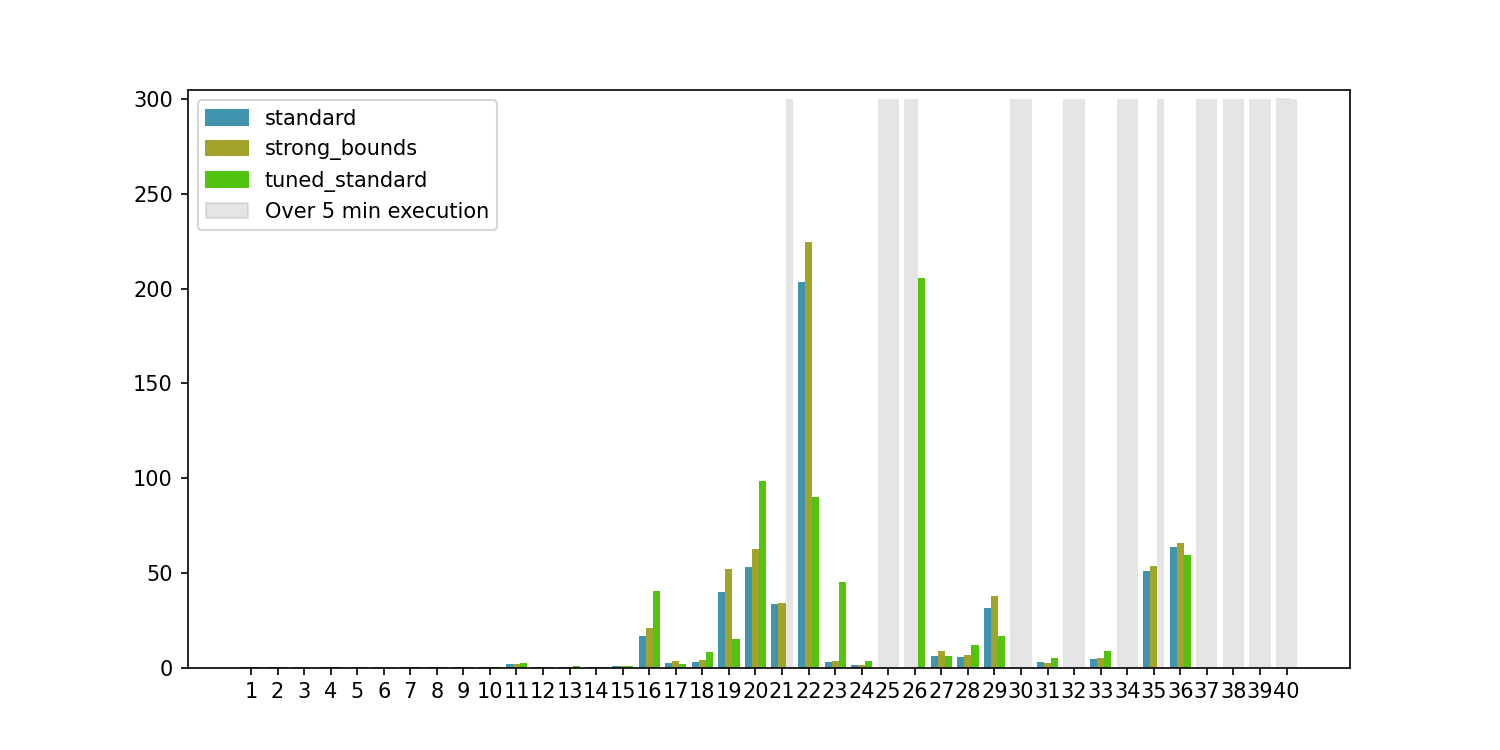

In [47]:
%matplotlib notebook
standard_data = pd.read_csv('stats/standard.csv')
strong_bounds_data = pd.read_csv('stats/strong_bounds.csv')
tuned_standard_data = pd.read_csv('stats/tuned_standard.csv')

data = [standard_data['time'].to_list(), strong_bounds_data['time'].to_list(), tuned_standard_data['time'].to_list()]
labels = ['standard', 'strong_bounds', 'tuned_standard']

plot_bar_graph(data, labels, figsize=(10, 5), y_lim=305)